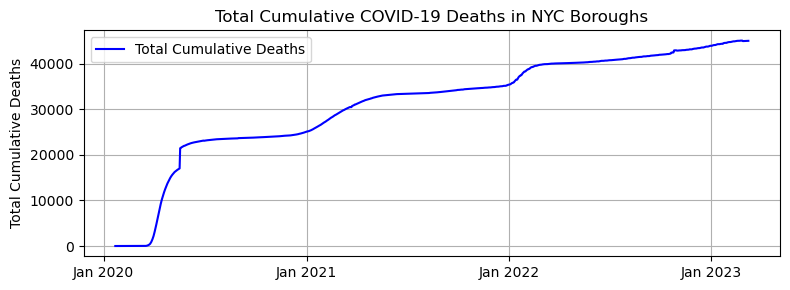

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset from local file
data = pd.read_csv('time_series_covid19_deaths_US.csv')

# Filter for NYC metro area counties (boroughs)
nyc_counties = ["Bronx", "Kings", "New York", "Queens", "Richmond"]
nyc_data = data[(data['Province_State'] == 'New York') & (data['Admin2'].isin(nyc_counties))]

# Select date columns for cumulative death counts
date_columns = nyc_data.columns[nyc_data.columns.str.match(r'\d+/\d+/\d+')]
cumulative_deaths = nyc_data[date_columns].sum(axis=0).astype(int)

# Convert the date columns to a datetime index
cumulative_deaths.index = pd.to_datetime(cumulative_deaths.index, format='%m/%d/%y')

# Plot cumulative deaths with year ticks on x-axis
plt.figure(figsize=(8, 3))
plt.plot(cumulative_deaths.index, cumulative_deaths.values, label="Total Cumulative Deaths", color='blue')
plt.ylabel("Total Cumulative Deaths")
plt.title("Total Cumulative COVID-19 Deaths in NYC Boroughs")

# Set x-ticks for the beginning of each year, including Jan 2020
year_start_dates = pd.date_range(start='2020-01-01', end=cumulative_deaths.index.max(), freq='AS')
year_labels = [date.strftime('%b %Y') for date in year_start_dates]

# Set x-ticks and labels for the beginning of each year
plt.xticks(ticks=year_start_dates, labels=year_labels, rotation=0)  # Set rotation to 0 for horizontal labels

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

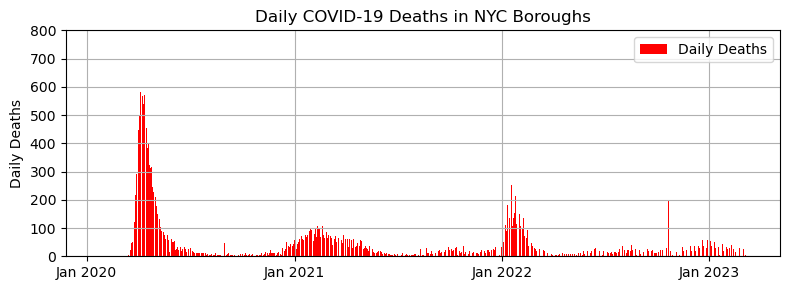

In [2]:
# Calculate daily deaths by differencing cumulative deaths
daily_deaths = cumulative_deaths.diff().fillna(0).astype(int)

# Plot daily deaths
plt.figure(figsize=(8, 3))
plt.bar(daily_deaths.index, daily_deaths.values, color='red', label="Daily Deaths")
plt.ylim(0, 800)  # Set y-axis range from 0 to 1000
plt.ylabel("Daily Deaths")
plt.title("Daily COVID-19 Deaths in NYC Boroughs")

# Set x-ticks for the beginning of each year, including Jan 2020
plt.xticks(ticks=year_start_dates, labels=year_labels, rotation=0)

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

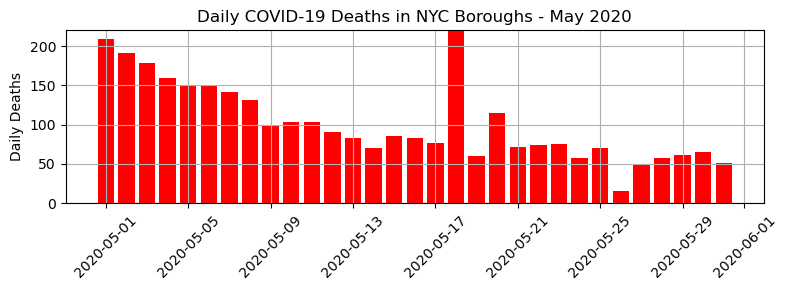

In [3]:
# Filter daily deaths for May 2020
may_2020_deaths = daily_deaths['2020-05-01':'2020-05-31']

# Plot daily deaths for May 2020
plt.figure(figsize=(8, 3))
plt.bar(may_2020_deaths.index, may_2020_deaths.values, color='red', label="Daily Deaths in May 2020")
plt.ylim(0, 220)  # Adjust y-axis range as needed
plt.ylabel("Daily Deaths")
plt.title("Daily COVID-19 Deaths in NYC Boroughs - May 2020")

# Set x-ticks to show each day in May
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

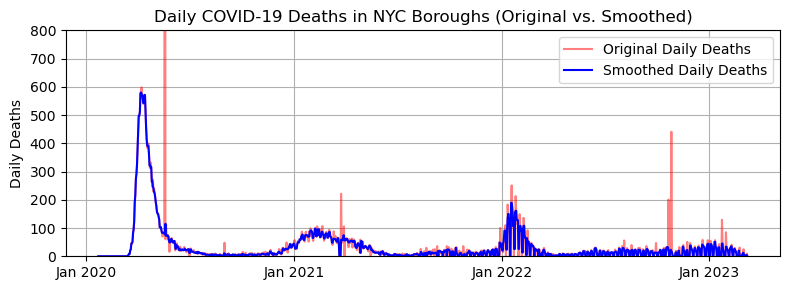

In [4]:
# Apply a rolling median filter to smooth out spikes (using a 3-day window)
smoothed_daily_deaths = daily_deaths.rolling(window=3, center=True).median().fillna(daily_deaths)

# Plot the smoothed daily deaths for comparison
plt.figure(figsize=(8, 3))
plt.plot(daily_deaths.index, daily_deaths.values, color='red', label="Original Daily Deaths", alpha=0.5)
plt.plot(smoothed_daily_deaths.index, smoothed_daily_deaths.values, color='blue', label="Smoothed Daily Deaths")
plt.ylim(0, 800)  # Adjust y-axis as needed
plt.ylabel("Daily Deaths")

# Set x-ticks for the beginning of each year, including Jan 2020
plt.xticks(ticks=year_start_dates, labels=year_labels, rotation=0)

plt.title("Daily COVID-19 Deaths in NYC Boroughs (Original vs. Smoothed)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

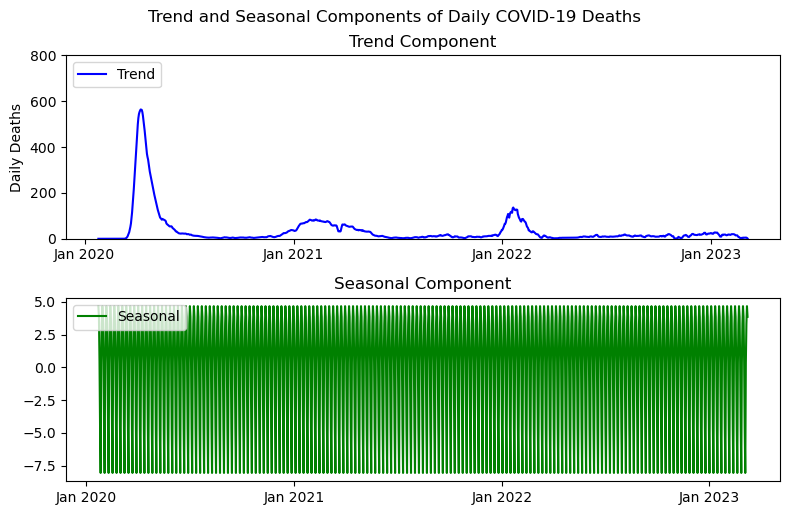

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Perform seasonal decomposition
decomposition = seasonal_decompose(smoothed_daily_deaths.dropna(), model='additive', period=7)

# Plot only the trend and seasonal components
plt.figure(figsize=(8, 5))

# Trend Component
plt.subplot(2, 1, 1)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.title('Trend Component')
plt.legend(loc="upper left")
plt.ylim(0, 800)  # Adjust y-axis as needed
plt.ylabel("Daily Deaths")
# Set x-ticks for the beginning of each year, including Jan 2020
plt.xticks(ticks=year_start_dates, labels=year_labels, rotation=0)

# Seasonal Component
plt.subplot(2, 1, 2)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.legend(loc="upper left")
# Set x-ticks for the beginning of each year, including Jan 2020
plt.xticks(ticks=year_start_dates, labels=year_labels, rotation=0)

plt.tight_layout()
plt.suptitle("Trend and Seasonal Components of Daily COVID-19 Deaths", y=1.02)
plt.show()

In [6]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time

# Assume decomposition.trend is already available and contains the trend component
trend_data = decomposition.trend.dropna().values.reshape(-1, 1)  # Remove NaN and reshape for scaling

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
trend_data_normalized = scaler.fit_transform(trend_data)

# Define a function to create sequences for supervised learning
def create_sequences(data, sequence_length=7):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Create sequences with a 7-day look-back window
sequence_length = 7
X, y = create_sequences(trend_data_normalized, sequence_length)

# Convert data to PyTorch tensors
X = torch.Tensor(X)
y = torch.Tensor(y)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Create DataLoader for training and validation
batch_size = 16
train_data = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_data = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

# Define the simple RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Get the output from the last time step
        out = self.fc(out)
        return out

# Instantiate and train the Simple RNN
simple_rnn = SimpleRNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(simple_rnn.parameters(), lr=0.001)

# Training loop for Simple RNN
epochs = 500
train_losses, val_losses = [], []
for epoch in range(epochs):
    simple_rnn.train()
    train_loss = 0
    for X_batch, y_batch in train_data:
        optimizer.zero_grad()
        y_pred = simple_rnn(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation loop
    simple_rnn.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_data:
            y_pred = simple_rnn(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    train_losses.append(train_loss / len(train_data))
    val_losses.append(val_loss / len(val_data))

    # Print every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Evaluate Simple RNN on validation set
simple_rnn.eval()
with torch.no_grad():
    y_val_pred_simple = simple_rnn(X_val).detach().numpy()

# Inverse transform the predictions and actual values for plotting
y_val_pred_simple = scaler.inverse_transform(y_val_pred_simple)
y_val_actual = scaler.inverse_transform(y_val.numpy().reshape(-1, 1))

# Get dates for validation set
dates = decomposition.trend.dropna().index[-len(y_val_actual):]

Epoch 50/500, Train Loss: 0.0001, Val Loss: 0.0000
Epoch 100/500, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 150/500, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 200/500, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 250/500, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 300/500, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 350/500, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 400/500, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 450/500, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 500/500, Train Loss: 0.0000, Val Loss: 0.0000


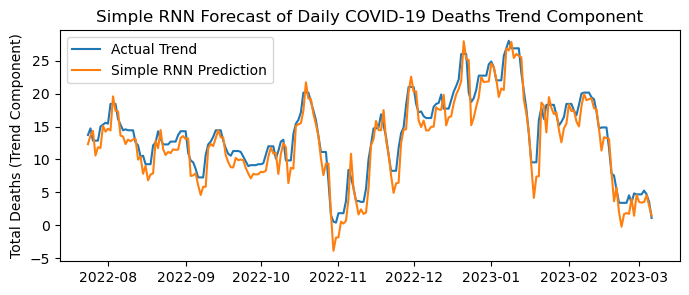

In [7]:
# Plot the results for Simple RNN with dates
plt.figure(figsize=(8, 3))
plt.plot(dates, y_val_actual, label="Actual Trend")
plt.plot(dates, y_val_pred_simple, label="Simple RNN Prediction")
plt.ylabel("Total Deaths (Trend Component)")
plt.title("Simple RNN Forecast of Daily COVID-19 Deaths Trend Component")
plt.legend()
plt.show()